## Data Prep

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

In [3]:
# function to create bar plot
def bar_count(df, column):
    df_count = df.copy()
    df_count = df_count[column].value_counts().reset_index().sort_values('index')

    plt.bar(df_count['index'], df_count[column], align='center', alpha=0.5)
    plt.title(column)
    plt.show()

In [4]:
#read in dataframe
df = pd.read_csv("transactions_n100000.csv")

df.head()

,ticket_id,order_timestamp,location,item_name,item_count,lat,long
0,0x7901ee,2019-01-16 18:33:00,7,shake,2,41.794132,-88.010140
1,0x7901ee,2019-01-16 18:33:00,7,burger,2,41.794132,-88.010140
2,0x7901ee,2019-01-16 18:33:00,7,fries,2,41.794132,-88.010140
3,0x12b47f,2019-09-04 12:36:00,3,salad,1,41.884490,-87.627059
4,0x12b47f,2019-09-04 12:36:00,3,fries,1,41.884490,-87.627059


In [5]:
# get rid of item details in order to get unique ticket_id
df_ticket = df.drop(['item_name','item_count'], axis =1).drop_duplicates()

# change to date time
df_ticket['order_timestamp'] = pd.to_datetime(df_ticket['order_timestamp'])

# create hour
df_ticket['hour'] = df_ticket['order_timestamp'].dt.hour

def hour_type(x):
    if x > 10 and x < 15:
        return "Lunch"
    elif x >= 15 and x < 22:
        return "Dinner"
    else:
        return "Late Night"

df_ticket['hour_type'] = df_ticket['hour'].apply(hour_type)

# day
df_ticket['day'] = df_ticket['order_timestamp'].dt.dayofweek

df_ticket.head()

,ticket_id,order_timestamp,location,lat,long,hour,hour_type,day
0,0x7901ee,2019-01-16 18:33:00,7,41.794132,-88.010140,18,Dinner,2
3,0x12b47f,2019-09-04 12:36:00,3,41.884490,-87.627059,12,Lunch,2
5,0x6d6979,2019-03-18 00:27:00,6,41.784576,-87.607565,0,Late Night,0
7,0x78dd1e,2019-09-22 00:10:00,2,42.049306,-87.677606,0,Late Night,6
10,0x4df8ab,2019-01-17 11:35:00,8,41.894202,-87.620965,11,Lunch,3


In [6]:
#pivot items
items = pd.pivot_table(df, index = 'ticket_id', columns = 'item_name', values ='item_count', aggfunc ='sum', fill_value= 0).reset_index()

items.head()

item_name,ticket_id,burger,fries,salad,shake
0,0x10000a,1,1,0,0
1,0x100058,2,2,0,0
2,0x1000c8,4,5,1,4
3,0x10014c,1,1,0,0
4,0x1001d8,3,3,0,3


In [7]:
# create new features about items
items_newfeatures = items[['ticket_id']]

items_newfeatures['meal_no'] = items['fries'].values
items_newfeatures['burger_ind'] = np.where(items['burger'] > 0, 1, 0)
items_newfeatures['salad_ind'] = np.where(items['salad'] > 0, 1, 0)
items_newfeatures['shake_ind'] = np.where(items['shake'] > 0, 1, 0)

items_newfeatures.head()

/Users/Sandra/Documents/Assignments/2/Customer_Segmentation/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/Sandra/Documents/Assignments/2/Customer_Segmentation/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/Sandra/Documents/Assignments/2/Customer_Segmentation/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 

item_name,ticket_id,meal_no,burger_ind,salad_ind,shake_ind
0,0x10000a,1,1,0,0
1,0x100058,2,1,0,0
2,0x1000c8,5,1,1,1
3,0x10014c,1,1,0,0
4,0x1001d8,3,1,0,1


In [8]:
#join item features to df_ticket
df_ticket = df_ticket.merge(items_newfeatures, on = 'ticket_id')

print(len(df_ticket))
df_ticket.head()

100000


,ticket_id,order_timestamp,location,lat,long,hour,hour_type,day,meal_no,burger_ind,salad_ind,shake_ind
0,0x7901ee,2019-01-16 18:33:00,7,41.794132,-88.010140,18,Dinner,2,2,1,0,1
1,0x12b47f,2019-09-04 12:36:00,3,41.884490,-87.627059,12,Lunch,2,1,0,1,0
2,0x6d6979,2019-03-18 00:27:00,6,41.784576,-87.607565,0,Late Night,0,2,1,0,0
3,0x78dd1e,2019-09-22 00:10:00,2,42.049306,-87.677606,0,Late Night,6,2,1,0,1
4,0x4df8ab,2019-01-17 11:35:00,8,41.894202,-87.620965,11,Lunch,3,3,0,1,0


In [9]:
# turning categorical into binary
df_dummies = df_ticket[['location', 'hour_type']].astype(str)
#df_ticket['location'] = df_ticket['location'].astype(str)

df_dummies = pd.get_dummies(df_dummies, drop_first = False)

df_dummies.head()

,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9,hour_type_Dinner,hour_type_Late Night,hour_type_Lunch
0,0,0,0,0,0,0,1,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,0,1


In [10]:
df_model = df_ticket[['ticket_id','meal_no', 'burger_ind', 'salad_ind', 'shake_ind']]

df_model = pd.concat([df_model,df_dummies], axis = 1)

df_model.head()

,ticket_id,meal_no,burger_ind,salad_ind,shake_ind,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9,hour_type_Dinner,hour_type_Late Night,hour_type_Lunch
0,0x7901ee,2,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0
1,0x12b47f,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0x6d6979,2,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0x78dd1e,2,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0
4,0x4df8ab,3,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


In [11]:
# plot location

df_location = df_ticket.groupby(['lat', 'long', 'location']).ticket_id.agg('count').reset_index()

df_location.head()

df_location.to_csv('location_count.csv', index = False)

## Data Exploration

In [9]:
print("Rows in dataframe: %d" % len(df.ticket_id))
print("Unique tickets: %d" % len(df.ticket_id.unique()))

Rows in dataframe: 260645
Unique tickets: 100000


#### Exploring Items

In [141]:
# burgers and salad are meals. fries match them.
# can create a number of meals and also a y/n flag for salad and burgers
sum(items['burger'] + items['salad'] == items['fries'])

100000

<BarContainer object of 3 artists>

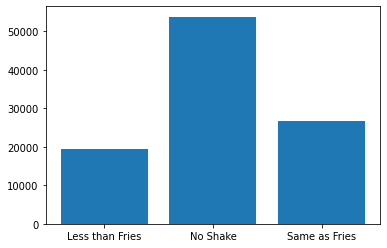

In [158]:
# people most likely to not get shakes. Then split between getting same as fries or less than fries.
# i think i can group it as a yes/no flag

shake = []

for i in range(0,len(items)):
    if items.iloc[i,4] == 0:
        shake.append("No Shake")
    elif items.iloc[i,4] == items.iloc[i,2]:
        shake.append("Same as Fries")
    elif items.iloc[i,4] < items.iloc[i,2]:
        shake.append("Less than Fries")
    else:
        shake.append("More than Fries")

plt.bar(np.unique(shake, return_counts=True)[0],np.unique(shake, return_counts=True)[1])

In [126]:
items.describe()

item_name,burger,fries,salad,shake
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.857840,2.569210,0.711370,1.239590
std,1.588589,1.332084,1.086524,1.627886
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000
50%,1.000000,2.000000,0.000000,0.000000
75%,3.000000,4.000000,1.000000,3.000000
max,5.000000,5.000000,5.000000,5.000000


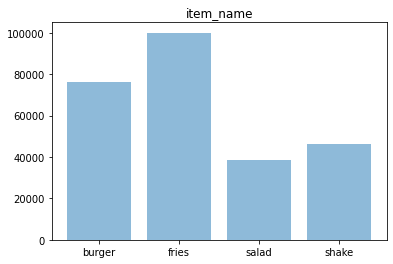

In [79]:
# fries appears in every order

bar_count(df, 'item_name')

In [15]:
item_count = df.item_name.value_counts().reset_index()
item_count['pct'] = item_count['item_name']/100000

item_count

,index,item_name,pct
0,fries,100000,1.00000
1,burger,76122,0.76122
2,shake,46156,0.46156
3,salad,38367,0.38367


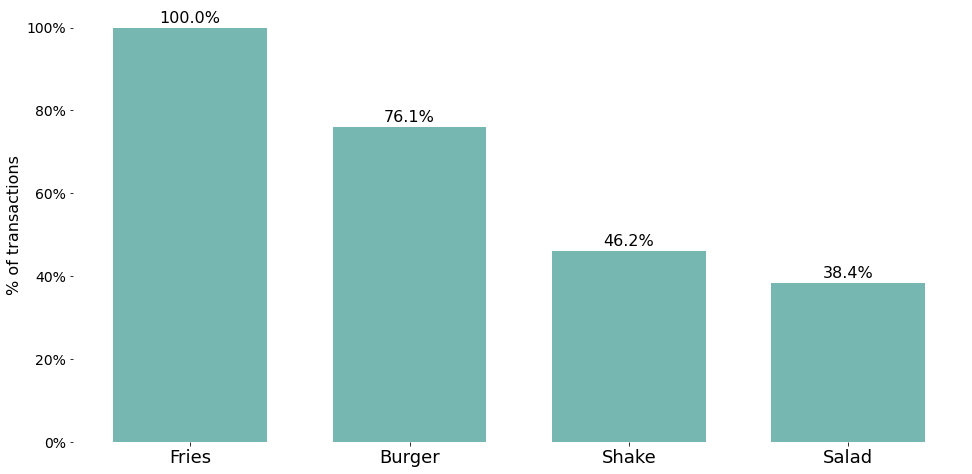

In [31]:
params = {'figure.figsize': (16,8),
          "font.size" : 16,
          'axes.labelsize': 16,
          'axes.titlesize': 18,
          'xtick.labelsize': 18,
          'ytick.labelsize': 14}
plt.rcParams.update(params)

N = len(item_count)

fig, ax = plt.subplots()
plt.box(False)

ind = np.arange(N)    # the x locations for the groups
width = 0.7         # the width of the bars

p1 = ax.bar(ind, item_count['pct'], width, bottom=0, color = '#76b7b2')

#ax.set_title(title)
ax.set(xlabel='', ylabel = '% of transactions', title= '')
ax.set_xticks(ind)
ax.set_xticklabels(['Fries', 'Burger', 'Shake', 'Salad'])

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.autoscale_view()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:,.1%}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),  # points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(p1)

plt.show()

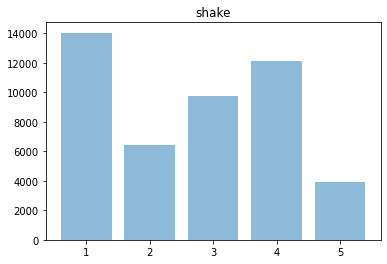

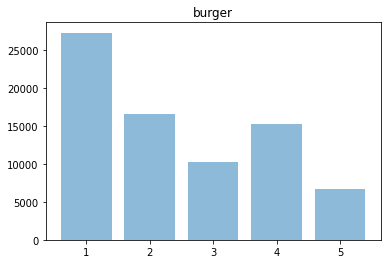

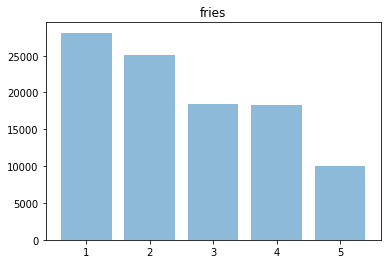

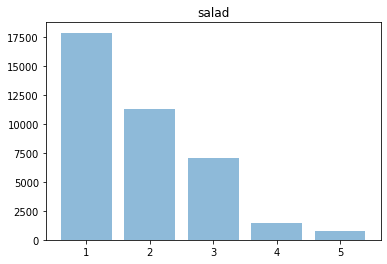

In [128]:
#how many orders for each item
for item in df['item_name'].unique():
    item_count = df[df['item_name'] == item]['item_count'].value_counts().reset_index()

    plt.bar(item_count['index'], item_count['item_count'], align='center', alpha=0.5)
    plt.title(item)
    plt.show()

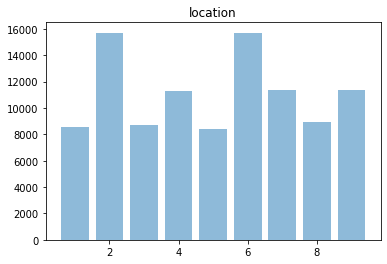

In [80]:
bar_count(df_ticket, 'location')

#### Looking at Dates

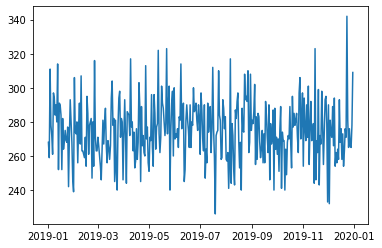

In [178]:
# only 2019 data
date_count = df_ticket['order_timestamp'].dt.date.value_counts().reset_index().sort_values('index')

plt.plot(date_count['index'], date_count['order_timestamp'])


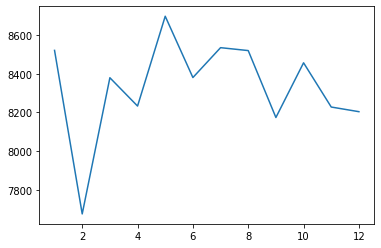

In [179]:
month_count = df_ticket['order_timestamp'].dt.month.value_counts().reset_index().sort_values('index')

plt.plot(month_count['index'], month_count['order_timestamp'])

# less in feb but I think it's because of less days in month. Generally quite stable.

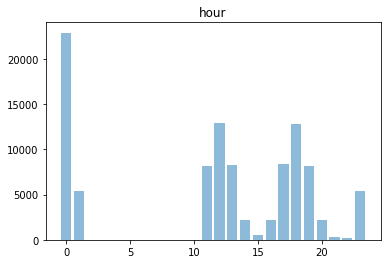

In [81]:
bar_count(df_ticket, 'hour')

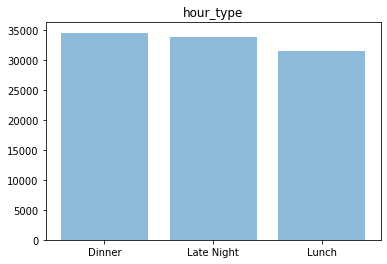

In [107]:
bar_count(df_ticket, 'hour_type')

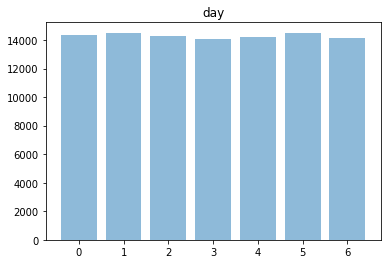

In [108]:
bar_count(df_ticket, 'day')

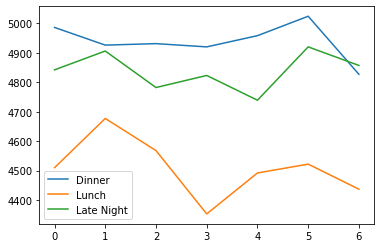

In [121]:
dayandhour = pd.pivot_table(df_ticket, columns = 'hour_type', index = 'day', values = 'ticket_id', aggfunc ='count').reset_index()

dayandhour

p1, = plt.plot(dayandhour['day'], dayandhour['Dinner'], label = "Dinner")
p2, = plt.plot(dayandhour['day'], dayandhour['Lunch'], label = "Lunch")
p3, = plt.plot(dayandhour['day'], dayandhour['Late Night'], label = "Late Night")

leg = plt.legend()

plt.show()

# looks pretty stable

## Create Clusters

In [28]:
df_model.iloc[:,:]

,ticket_id,meal_no,salad_ind,shake_ind,location_1,location_2,location_3,location_4,location_5,location_6,...,hour_type_Dinner,hour_type_Late Night,hour_type_Lunch,day_0,day_1,day_2,day_3,day_4,day_5,day_6
2,0x6d6979,2,0,0,0,0,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
3,0x78dd1e,2,0,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0x4df8ab,3,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
5,0x3be6d3,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
6,0x755a0b,4,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0x804d8d,5,0,1,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
99996,0x7b618c,4,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
99997,0x75ab27,1,1,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
99998,0x560060,2,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0


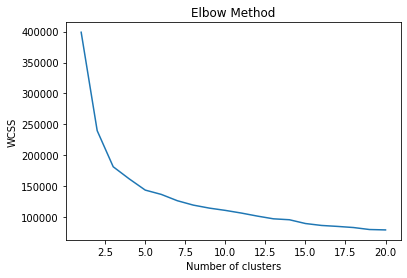

In [50]:
# determine k - look at wcss for each number of clustrs to determine how number of clusters
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, init='k-means++', tol = 1e-6, n_init=10, random_state=0)
    kmeans.fit(df_model.iloc[:,1:])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [11]:
# create model
nclusters = 3

kmeans = KMeans(n_clusters=nclusters, init='k-means++', tol = 1e-6, n_init=10, random_state=0).fit(df_model.iloc[:,2:])
clusters = kmeans.fit_predict(df_model.iloc[:,1:])

In [12]:
centroids = pd.DataFrame(kmeans.cluster_centers_)

centroids.columns = df_model.columns[1:]

centroids

,meal_no,burger_ind,salad_ind,shake_ind,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9,hour_type_Dinner,hour_type_Late Night,hour_type_Lunch
0,2.103535,0.221773,0.993912,0.077937,0.199011,0.038986,0.198699,0.040093,0.202885,0.040231,0.042237,0.198353,0.039505,0.035388,0.008890,0.955722
1,4.084550,0.974903,0.239110,0.901748,0.043732,0.066059,0.045491,0.227745,0.042635,0.068280,0.226158,0.051895,0.228004,0.825420,0.104800,0.069780
2,1.496651,0.985972,0.036952,0.347087,0.035579,0.337506,0.038352,0.061165,0.029128,0.333553,0.062867,0.039093,0.062757,0.135480,0.823011,0.041509


In [13]:
np.unique(clusters, return_counts=True)

(array([0, 1, 2], dtype=int32), array([28908, 34666, 36426]))